# Within Top 10% with Simple Regression Model.

# Step By Step Procedure To Predict House Price

# Importing packages
We have **numpy** and **pandas** to work with numbers and data, and we have **seaborn** and **matplotlib** to visualize data. We would also like to filter out unnecessary warnings. **Scipy** for normalization and skewing of data.

In [0]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Loading and Inspecting data
With various Pandas functions, we load our training and test data set as well as inspect it to get an idea of the data we're working with. This is a large dataset we will be working on.


In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
print ("Size of train data : {}" .format(train.shape))

print ("Size of test data : {}" .format(test.shape))

Size of train data : (1460, 81)
Size of test data : (1459, 80)


> That is a very large data set! We are going to have to do a lot of work to clean it up

**Drop the Id column because we dont need it currently.**

In [0]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [5]:
print ("Size of train data after dropping Id: {}" .format(train.shape))
print ("Size of test data after dropping Id: {}" .format(test.shape))

Size of train data after dropping Id: (1460, 80)
Size of test data after dropping Id: (1459, 79)


## Dealing with outliers

Outlinear in the GrLivArea is recommended by the author of the data  to remove it. The author says in documentation “I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.”


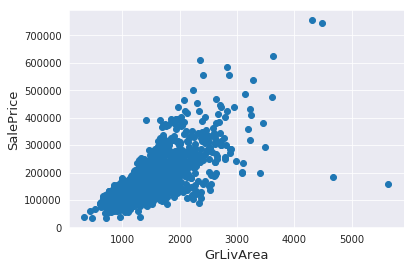

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can see that there are outlinear with low SalePrice and high GrLivArea. This looks odd.
We need to remove it.

In [0]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

## Correlation Analysis

Let see the most correlated features.

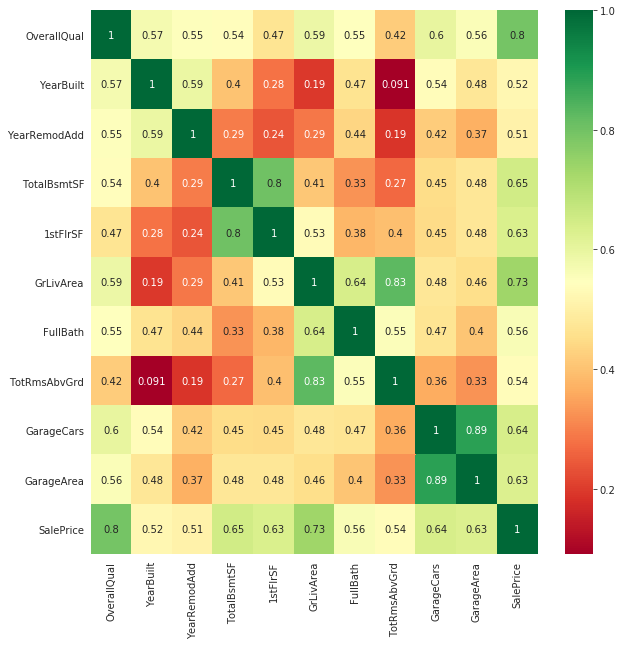

In [8]:
# most correlated features
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

- From this we can tell which features **(OverallQual, GrLivArea and TotalBsmtSF )** are highly positively correlated with the SalePrice. 
- **GarageCars and GarageArea ** also seems correlated with other, Since the no. of car that will fit into the garage will depend on GarageArea. 

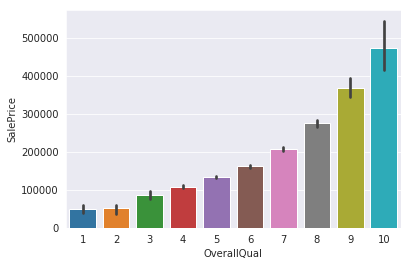

In [9]:
sns.barplot(train.OverallQual,train.SalePrice)

**Scatter plots between 'SalePrice' and correlated variables**

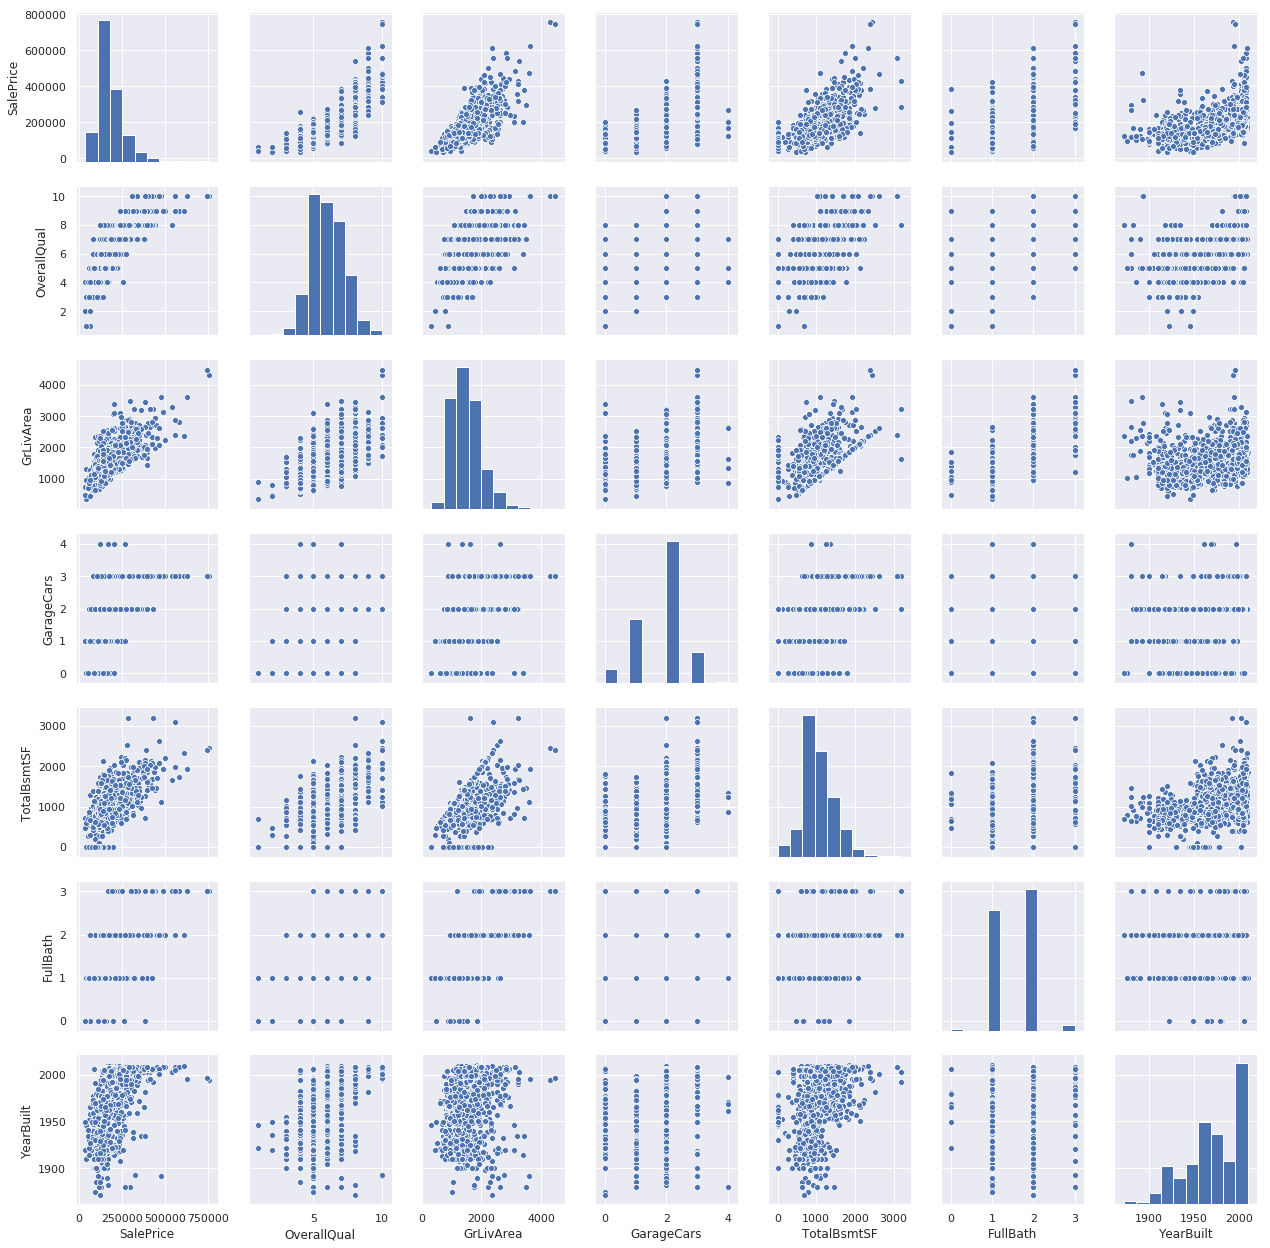

In [10]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

One of the figures we may find interesting is the one between ** 'TotalBsmtSF' and 'GrLiveArea'. **

We can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area

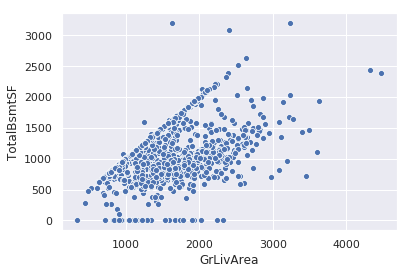

In [11]:
sns.scatterplot(train.GrLivArea,train.TotalBsmtSF)

## Target Variable Transform
Different features in the data set may have values in different ranges. For example, in this data set, the range of SalePrice feature may lie from thousands to lakhs but the range of values of YearBlt feature will be in thousands. That means a column is more weighted compared to other.

**Lets check the skewness of data**
![Skew](https://cdn-images-1.medium.com/max/800/1*hxVvqttoCSkUT2_R1zA0Tg.gif)


 mu = 180932.92 and sigma = 79467.79



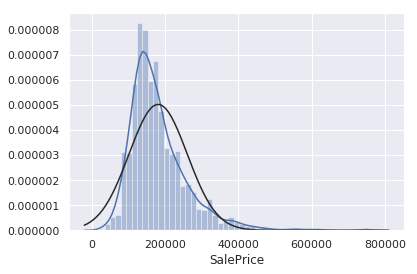

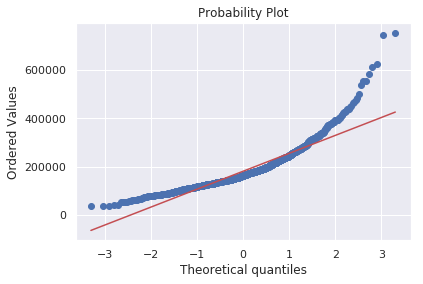

In [12]:
def check_skewness(col):
    sns.distplot(train[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness('SalePrice')

**This distribution is positively skewed.** Notice that the black curve is more deviated towards the right. If you encounter that your predictive (response) variable is skewed, it is **recommended to fix the skewness** to make good decisions by the model.

## Okay, So how do I fix the skewness?
The best way to fix it is to perform a **log transform** of the same data, with the intent to reduce the skewness.


 mu = 12.02 and sigma = 0.40



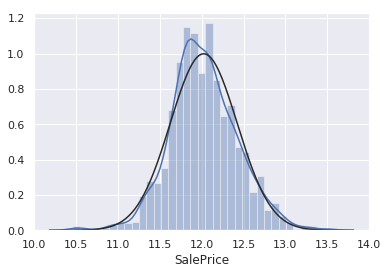

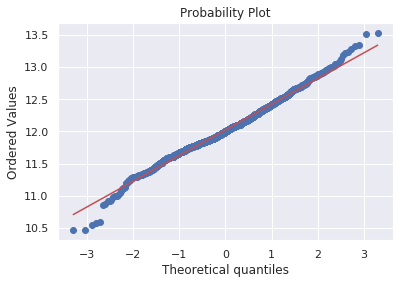

In [13]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

check_skewness('SalePrice')

After taking logarithm of the same data the curve seems to be normally distributed, although not perfectly normal, this is sufficient to fix the issues from a skewed dataset as we saw before.

**Important : If you log transform the response variable, it is required to also log transform feature variables that are skewed.**

# Feature Engineering

Here is the [Documentation](http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt) you can refer , to know more about the dataset.

**Concatenate both train and test values.**

In [14]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


# Missing Data

In [0]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

Text(0.5, 1.0, 'Percent missing data by feature')

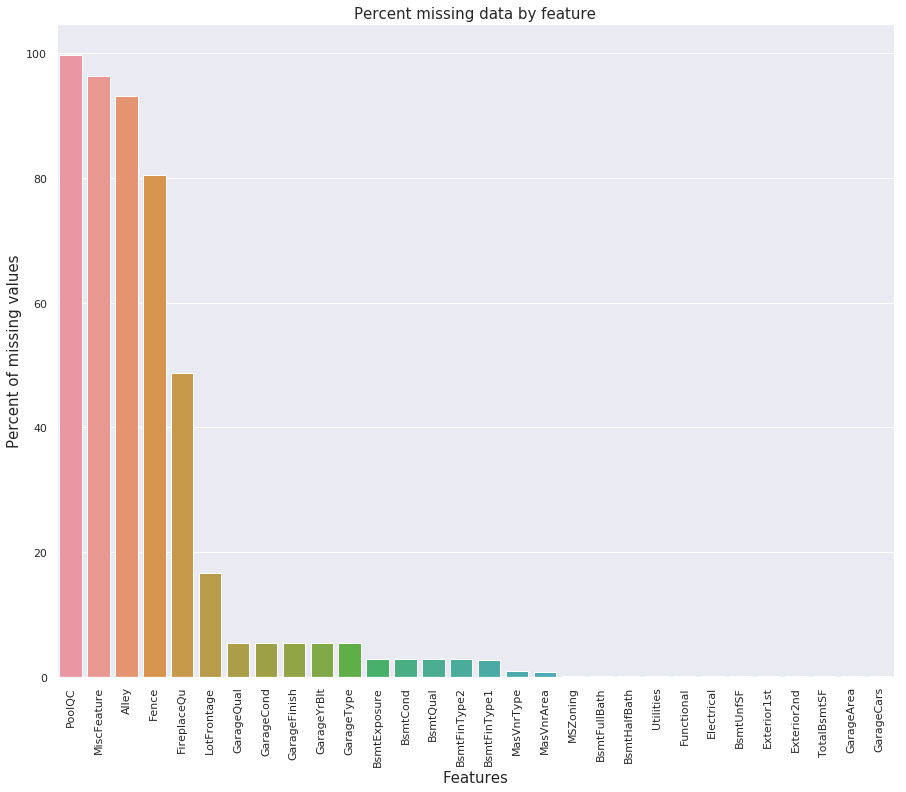

In [16]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [17]:
all_data.PoolQC.loc[all_data.PoolQC.notnull()]

197     Ex
809     Fa
1169    Gd
1181    Ex
1384    Fa
1421    Gd
1972    Ex
2571    Ex
2708    Gd
Name: PoolQC, dtype: object

**GarageType,  GarageFinish, GarageQual,  GarageCond, GarageYrBlt,  GarageArea,  GarageCars  these all features have same percentage of null values.**

# Handle Missing Data

Since PoolQC has the highest null values according to the data documentation says **null values means 'No Pool.**
Since majority of houses has no pool.
So we will replace those null values with 'None'.

In [0]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

* **MiscFeature** : Data documentation says NA means "no misc feature"

In [0]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

* **Alley** : data description says NA means "no alley access"


In [0]:
all_data["Alley"] = all_data["Alley"].fillna("None")

* **Fence** : data description says NA means "no fence"


In [0]:
all_data["Fence"] = all_data["Fence"].fillna("None")

* **FireplaceQu** : data description says NA means "no fireplace"

In [0]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

* **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [23]:
# Grouping by Neighborhood and Check the LotFrontage. Most of the grouping has similar areas
grouped_df = all_data.groupby('Neighborhood')['LotFrontage']

for key, item in grouped_df:
    print(key,"\n")
    print(grouped_df.get_group(key))
    break

Blmngtn 

219     43.0
229     43.0
385     43.0
443     53.0
465      NaN
558      NaN
596     53.0
638     53.0
789     43.0
850      NaN
981     43.0
1003    43.0
1018    43.0
1022    43.0
1125    53.0
1392    53.0
1413    51.0
1481    43.0
1683    43.0
1982     NaN
1983     NaN
1984    53.0
2318     NaN
2319    53.0
2669    43.0
2670     NaN
2671     NaN
2672    43.0
Name: LotFrontage, dtype: float64


In [0]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

* **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None as per documentation. 

In [0]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

In [26]:
abc = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt', 'GarageArea', 'GarageCars']
all_data.groupby('GarageType')[abc].count()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageArea,GarageCars
GarageType,,,,,,,
2Types,23,23,23,23,23,23,23
Attchd,1722,1722,1722,1722,1722,1722,1722
Basment,36,36,36,36,36,36,36
BuiltIn,185,185,185,185,185,185,185
CarPort,15,15,15,15,15,15,15
Detchd,779,779,779,779,777,778,778
None,157,157,157,157,0,157,157


* **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [0]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [0]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no basement.

In [0]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

* **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [0]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

* **MSZoning (The general zoning classification)** : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [31]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [0]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

* **Utilities** : Since this is a categorical data and most of the data are of same category, Its not gonna effect on model. So we choose to drop it.

In [33]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [0]:
all_data = all_data.drop(['Utilities'], axis=1)

* **Functional** : data description says NA means typical

In [0]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

* **Electrical,KitchenQual, Exterior1st, Exterior2nd, SaleType** : Since this all are categorical values so its better to replace nan values with the most used keyword.

In [0]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

* **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [0]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

## Lets check for any missing values

In [38]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


**Now there any many features that are numerical but categorical.**

In [39]:
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

**Converting some numerical variables that are really categorical type.**

As you can see the category range from 1 to 9 which are numerical (**not ordinal type**). Since its categorical we need to change it to String type.

If we do not convert these to categorical, some model may get affect by this as model will compare the value 1<5<10 . We dont need that to happen with our model.

In [0]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

## Label Encoding 
As you might know by now, we can’t have text in our data if we’re going to run any kind of model on it. So before we can run a model, we need to make this data ready for the model.

And to convert this kind of categorical text data into model-understandable numerical data, we use the Label Encoder class.

Suppose, we have a feature State which has 3 category i.e India , France, China . So, Label Encoder will categorize them as 0, 1, 2.

In [41]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [0]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**Lets see the highly skewed features we have**

In [43]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


## Box Cox Transformation of (highly) skewed features

When you are dealing with real-world data, you are going to deal with features that are heavily skewed. Transformation technique is useful to **stabilize variance**, make the data **more normal distribution-like**, improve the validity of measures of association.

The problem with the Box-Cox Transformation is **estimating lambda**. This value will depend on the existing data, and should be considered when performing cross validation on out of sample datasets.

In [44]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

In [45]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

Creating train and test data.

In [46]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1458, 220)

In [47]:
test.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotFrontage,LotShape,LowQualFinSF,...,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
1458,11.818680,0.000000,0.0,0.730463,1.194318,1.820334,1.540963,10.105326,7.397498,2.055642,1.540963,0.0,0.0,1.820334,8.780689,0.730463,0.0,1.820334,1.540963,1.194318,1.540963,0.000000,0.730463,2.259674,11.259868,0.730463,2.055642,1.540963,2.055642,14.121376,11.818680,0.000000,1.820334,0.730463,1.540963,0.0,20.479373,6.221214,1.540963,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1459,12.943735,0.000000,0.0,0.730463,1.540963,1.820334,1.540963,11.901094,0.000000,0.000000,2.259674,0.0,0.0,1.820334,9.752379,0.730463,0.0,1.820334,1.540963,1.820334,1.540963,0.000000,0.730463,2.259674,9.118181,0.730463,2.055642,1.540963,2.055642,14.116605,12.943735,0.730463,1.820334,0.730463,1.194318,0.0,21.327220,6.244956,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1460,11.916131,11.151348,0.0,0.730463,1.540963,1.820334,1.540963,11.476685,0.000000,1.194318,2.259674,0.0,0.0,1.194318,7.293500,0.730463,0.0,1.820334,1.540963,1.194318,2.055642,0.730463,1.194318,2.259674,10.179489,1.194318,2.055642,0.000000,2.055642,14.178149,13.551272,0.730463,1.194318,0.730463,1.540963,0.0,21.196905,6.073289,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1461,11.910125,11.062536,0.0,0.730463,1.540963,1.820334,1.540963,10.749651,0.000000,1.194318,2.259674,0.0,0.0,1.820334,9.207511,0.730463,0.0,1.820334,1.540963,1.820334,1.194318,0.730463,1.194318,2.259674,10.116035,1.194318,2.055642,0.000000,2.055642,14.179714,13.504453,0.730463,0.000000,0.730463,1.194318,0.0,19.865444,6.172972,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1462,12.833625,0.000000,0.0,0.730463,1.194318,1.820334,1.540963,8.720170,0.000000,0.000000,2.259674,0.0,0.0,1.194318,12.172900,0.730463,0.0,1.820334,1.194318,1.820334,1.540963,0.000000,1.194318,2.259674,10.302477,1.194318,2.055642,1.194318,2.055642,14.170316,12.833625,0.000000,0.000000,0.730463,1.194318,0.0,17.257255,5.093857,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


## Lets apply Modelling

1. Importing Libraries

2. We will use models
 - Lasso
 - Ridge
 - ElasticNet
 - Gradient Boosting
 
3. Find the Cross Validation Score.
4. Calculate the mean of all model's prediction.
5. Submit the CSV file.
 

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Cross Validation
It's simple way to calculate error for evaluation. 

**KFold( )** splits the train/test data into k consecutive folds, we also have made shuffle attrib to True.

**cross_val_score ( )** evaluate a score by cross-validation.

In [0]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Modelling
Since in this dataset we have a large set of features. So to make our model avoid Overfitting and noisy we will use Regularization.
These model have Regularization parameter.

Regularization will reduce the magnitude of the coefficients.

## Ridge Regression
- It shrinks the parameters, therefore it is mostly used to prevent multicollinearity.
- It reduces the model complexity by coefficient shrinkage.
- It uses L2 regularization technique.

In [50]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



## Lasso Regression
LASSO (Least Absolute Shrinkage Selector Operator), is quite similar to ridge.

In case of lasso, even at smaller alpha’s, our coefficients are reducing to absolute zeroes.
 Therefore, lasso selects the only some feature while reduces the coefficients of others to zero. This property is known as feature selection and which is absent in case of ridge.
 
- Lasso uses L1 regularization technique.
- Lasso is generally used when we have more number of features, because it automatically does feature selection.


In [51]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1115 (0.0074)



## Elastic Net Regression

Elastic net is basically a combination of both L1 and L2 regularization. So if you know elastic net, you can implement both Ridge and Lasso by tuning the parameters.

In [52]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



## Gradient Boosting Regression
Refer [here](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)

In [53]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



**Fit the training dataset on every model**

In [0]:
LassoMd = lasso.fit(train.values,y_train)
ENetMd = ENet.fit(train.values,y_train)
KRRMd = KRR.fit(train.values,y_train)
GBoostMd = GBoost.fit(train.values,y_train)

## Mean of all model's prediction.
np.expm1 ( ) is used to calculate exp(x) - 1 for all elements in the array. 

In [55]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(ENetMd.predict(test.values)) + np.expm1(KRRMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values)) ) / 4
finalMd

array([120177.72631577, 163816.91476835, 183417.48473384, ...,
       171142.03348026, 114284.70143212, 222131.78687059])

## Submission

In [0]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
sub.to_csv('submission.csv',index=False)

**If you found this notebook helpful or you just liked it , some upvotes would be very much appreciated.**

**I'll be glad to hear suggestions on improving my models**

In [57]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotFrontage,LotShape,LowQualFinSF,...,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,11.692623,11.686189,0.0,0.730463,1.540963,1.820334,1.540963,11.170327,0.0,1.194318,2.259674,0.730463,0.000000,1.194318,7.483296,0.730463,0.000000,1.820334,1.194318,1.820334,1.540963,0.000000,1.194318,2.259674,10.506271,1.194318,2.055642,1.194318,2.055642,14.187527,13.698888,0.730463,0.000000,0.730463,1.194318,0.0,19.212182,5.831328,1.540963,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,12.792276,0.000000,0.0,0.730463,1.540963,1.820334,0.730463,12.062832,0.0,0.000000,2.259674,0.000000,0.730463,1.194318,8.897844,0.730463,0.000000,1.820334,1.540963,1.820334,2.055642,0.730463,1.194318,2.259674,10.062098,1.194318,2.055642,1.194318,2.055642,14.145138,12.792276,0.000000,0.000000,0.730463,1.540963,0.0,19.712205,6.221214,1.540963,0.0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,11.892039,11.724598,0.0,0.730463,1.540963,1.820334,1.194318,10.200343,0.0,1.194318,2.259674,0.730463,0.000000,1.194318,9.917060,0.730463,0.000000,1.820334,1.194318,1.820334,2.055642,0.730463,1.194318,2.259674,10.775536,1.194318,2.055642,1.194318,2.055642,14.184404,13.832085,0.730463,0.000000,0.730463,1.194318,0.0,20.347241,5.914940,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,12.013683,11.354094,0.0,0.730463,1.540963,0.730463,1.540963,8.274266,0.0,0.000000,2.259674,0.730463,0.000000,1.820334,10.468500,0.730463,8.797736,1.820334,1.540963,1.820334,1.194318,0.730463,0.730463,2.259674,10.918253,1.540963,2.055642,1.540963,2.055642,14.179714,13.711364,0.000000,1.194318,0.730463,1.194318,0.0,19.691553,5.684507,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,12.510588,12.271365,0.0,0.730463,1.820334,1.820334,0.000000,10.971129,0.0,1.194318,2.259674,0.730463,0.000000,1.194318,10.221051,0.730463,0.000000,1.820334,1.194318,1.820334,2.055642,0.730463,1.194318,2.259674,11.627708,1.540963,2.055642,1.194318,2.055642,14.182841,14.480029,0.730463,0.000000,0.730463,1.194318,0.0,21.325160,6.314735,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [0]:
from sklearn.model_selection import train_test_split
X_train_val, X_test_val, y_train_val, y_test_val= train_test_split(train, y_train, random_state=23, test_size=.20)

In [59]:
X_train_val.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotFrontage,LotShape,LowQualFinSF,...,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
1289,12.528113,0.000000,0.0,0.730463,1.540963,1.820334,0.000000,12.164562,0.0,1.194318,2.259674,0.730463,0.0,1.820334,7.308628,0.730463,0.0,1.820334,1.540963,1.820334,1.194318,0.730463,0.730463,2.259674,10.189934,1.194318,2.055642,1.194318,2.055642,14.126140,12.528113,0.000000,1.820334,0.730463,1.540963,0.0,21.281392,6.047664,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
793,12.359144,11.537948,0.0,0.730463,1.540963,1.820334,1.540963,0.000000,0.0,2.259674,2.259674,0.000000,0.0,1.194318,11.192952,0.730463,0.0,1.820334,1.194318,1.820334,2.055642,0.730463,1.194318,2.259674,9.770476,1.194318,2.055642,0.000000,2.055642,14.173451,14.014950,0.730463,0.000000,0.730463,1.194318,0.0,20.194264,5.802739,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
83,12.303551,0.000000,0.0,0.730463,1.540963,1.820334,1.540963,0.000000,0.0,2.259674,2.259674,0.000000,0.0,1.820334,12.303551,0.730463,0.0,1.820334,1.540963,1.820334,1.540963,0.000000,0.730463,2.259674,10.067536,1.194318,2.055642,1.540963,2.055642,14.141979,12.303551,0.730463,1.194318,0.730463,1.540963,0.0,19.410835,6.221214,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
432,11.386070,10.740974,0.0,0.730463,1.194318,1.820334,1.540963,10.121375,0.0,0.000000,2.259674,0.730463,0.0,1.820334,8.978567,0.730463,0.0,1.820334,1.540963,1.820334,1.540963,0.000000,0.730463,1.194318,9.951172,1.194318,2.055642,1.540963,2.055642,14.137234,13.022455,0.730463,0.000000,0.730463,1.540963,0.0,14.055628,4.137711,1.540963,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
929,13.234258,0.000000,0.0,0.730463,1.540963,1.820334,0.000000,3.530419,0.0,1.194318,2.259674,0.000000,0.0,1.194318,13.201548,0.730463,0.0,1.820334,1.194318,1.820334,1.540963,0.000000,1.194318,2.259674,10.784117,1.540963,2.055642,0.000000,2.055642,14.193765,13.234258,0.000000,0.000000,0.730463,1.194318,0.0,19.425328,6.047664,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [0]:
import tensorflow as tf

tf.reset_default_graph()

learning_rate = 0.75 
num_steps =50000
beta = .55
hidden_1 = 16 
hidden_2 = 8
hidden_3 = 4 
input_dim = X_train_val.shape[1]
output_dim = 1  
n_epochs = 5000 
batch_size = 32
X_tf = tf.placeholder("float" ) 
y_tf = tf.placeholder("float" ) 

In [0]:
weights = {'w1': tf.Variable(tf.random_normal([input_dim, hidden_1])),  
           'w2': tf.Variable(tf.random_normal([hidden_1, hidden_2])),  
           'w3': tf.Variable(tf.random_normal([hidden_2, hidden_3])), 
           'out': tf.Variable(tf.random_normal([hidden_3, output_dim ])) }

biases = {'b1': tf.Variable(tf.random_normal([hidden_1])),
          'b2': tf.Variable(tf.random_normal([hidden_2])),
          'b3': tf.Variable(tf.random_normal([hidden_3])),
          'out': tf.Variable(tf.random_normal([output_dim])) } 

In [0]:
def ann_model(X_val): 
        layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1' ]) 
        layer_1 = tf.nn.relu(layer_1) 
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2) 
        layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3']) 
        layer_3 = tf.nn.relu(layer_3)
        layer_out = tf.add(tf.matmul(layer_3, weights['out']), biases ['out'],name="layer_out") 
        return layer_out 

In [0]:
# Model Construction 
model = ann_model(X_tf) 
# Mean Squared Error cost function
loss= tf.reduce_mean(tf.square(y_tf - model)) 

In [0]:

regularizer_1 = tf.nn.l2_loss(weights['w1']) 
regularizer_2 = tf.nn.l2_loss(weights['w2']) 
regularizer_3 = tf.nn.l2_loss(weights['w3']) 
cost = tf.reduce_mean(loss + beta*regularizer_1 + beta*regularizer_2 
                      + regularizer_3)

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) .minimize(cost)
init = tf.global_variables_initializer() 
saver = tf.train.Saver() 

In [66]:
max_checks_without_progress = 1500
checks_without_progress = 0
best_loss = np.infty
with tf.Session() as sess: 
        sess.run(init) 
        for i in range(num_steps): 
            sess.run(optimizer, feed_dict={X_tf:X_train_val, y_tf:y_train_val})  
            if (i+1)%100 == 0: 
                loss_val = cost.eval(feed_dict={X_tf: X_test_val, y_tf: y_test_val})
                print("batch no : ",i+1,"Loss",loss_val) 
                           #Check whether to stop or not
                if loss_val < best_loss:
                    save_path = saver.save(sess,"./Final_model.ckpt")
                    best_loss = loss_val
                    checks_without_progress = 0
                else:
                    checks_without_progress += 1
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
        save_path = saver.save(sess, "/tmp/final2.ckpt") 
        print("Model saved in path: %s" % save_path) 
        pred = sess.run(model, feed_dict={X_tf:test}) 
with tf.Session() as sess:
    saver.restore(sess, "./Final_model.ckpt")
    pred = sess.run(model, feed_dict={X_tf:test}) 


batch no :  100 Loss 9119.299
batch no :  200 Loss 7960.375
batch no :  300 Loss 7287.811
batch no :  400 Loss 6819.0605
batch no :  500 Loss 6459.8896
batch no :  600 Loss 6168.2583
batch no :  700 Loss 5922.356
batch no :  800 Loss 5709.701
batch no :  900 Loss 5522.4653
batch no :  1000 Loss 5355.3364
batch no :  1100 Loss 5204.487
batch no :  1200 Loss 5067.005
batch no :  1300 Loss 4940.5605
batch no :  1400 Loss 4823.4106
batch no :  1500 Loss 4713.8926
batch no :  1600 Loss 4610.891
batch no :  1700 Loss 4513.364
batch no :  1800 Loss 4420.4487
batch no :  1900 Loss 4331.3203
batch no :  2000 Loss 4245.4688
batch no :  2100 Loss 4162.409
batch no :  2200 Loss 4081.7275
batch no :  2300 Loss 4003.0603
batch no :  2400 Loss 3926.0698
batch no :  2500 Loss 3850.5027
batch no :  2600 Loss 3776.235
batch no :  2700 Loss 3703.008
batch no :  2800 Loss 3630.6904
batch no :  2900 Loss 3559.2036
batch no :  3000 Loss 3488.4646
batch no :  3100 Loss 3418.3455
batch no :  3200 Loss 3348.82

W0618 06:34:25.478430 140705428961152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


batch no :  50000 Loss 0.19141765
Model saved in path: /tmp/final2.ckpt


In [0]:
prediction = np.expm1(pred) 

In [0]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = prediction

sub.to_csv('submission_DNN_WD.csv',index=False)